# Integration of CITE-seq and scRNA-seq data

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi
from scipy.stats import pearsonr

## Imports and data loading

In [2]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq()

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                               
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1    PBMC10k
AAACCCACATCGGTTA-1    PBMC10k
AAACCCAGTACCGCGT-1    PBMC10k
AAACCCAGTATCGAAA-1    PBMC10k
AAACCCAGTCGTCATA-1    PBMC10k
                       ...   
TTTGGTTGTACGAGTG-1     PBMC5k
TTTGTTGAGTTAACAG-1     PBMC5k
TTTGTTGCAGCACAAG-1     PBMC5k
TTTGTTGCAGTCTTCC-1     PBMC5k
TTTGTTGCATTGCCGG-1     PBMC5k
Name: batch, Length: 10849, dtype: object

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. We will store the original values to validate after training.

In [5]:
held_out_proteins = adata.obsm["protein_expression"][batch == "PBMC5k"].copy()
adata.obsm["protein_expression"].loc[batch == "PBMC5k"] = np.zeros_like(
    adata.obsm["protein_expression"][batch == "PBMC5k"]
)

In [6]:
sc.pp.highly_variable_genes(
    adata, batch_key="batch", flavor="seurat_v3", n_top_genes=4000, subset=True
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


<div class="alert alert-info">

Important

scvi-tools will automatically detect proteins as missing in a certain batch if the protein has 0 counts for each cell in the batch. In other words, to indicate a protein is missing in a certain batch, please set it to 0 for each cell.

</div>

In [7]:
scvi.model.TOTALVI.setup_anndata(
    adata, batch_key="batch", protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                 
INFO     Found batches with missing protein expression                                       


## Prepare and run model

In [8]:
model = scvi.model.TOTALVI(adata, latent_distribution="normal", n_layers_decoder=2)

INFO     Computing empirical prior initialization for protein background.                    


/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.


In [9]:
model.train()

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:97: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/eecs/jjhong922/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1645690191318/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)


Epoch 400/400: 100%|██████████| 400/400 [11:24<00:00,  1.71s/it, loss=581, v_num=1]


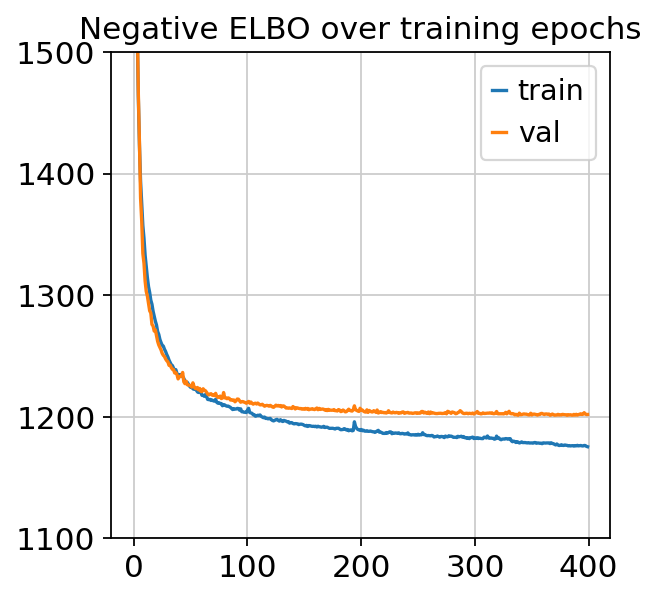

In [10]:
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

Again, we rely on Scanpy.

In [11]:
adata.obsm["X_totalVI"] = model.get_latent_representation()
adata.obsm["protein_fg_prob"] = model.get_protein_foreground_probability(
    transform_batch="PBMC10k"
)

rna, protein = model.get_normalized_expression(
    transform_batch="PBMC10k", n_samples=25, return_mean=True
)

<div class="alert alert-info">

Note

`transform_batch` is a power parameter. Setting this allows one to predict the expression of cells as if they came from the inputted batch. In this case, we've observed protein expression in batch "PBMC10k" (batch categories from original adata object), but we have no protein expression in batch "PBMC5k". We'd like to take the cells of batch "PBMC5k" and make a counterfactual prediction: "What would the expression look like if my batch "PBMC5k" cells came from batch "PBMC10k"?"

</div>

In [12]:
protein.iloc[:5, :5]

CD3_TotalSeqB  CD4_TotalSeqB  CD8a_TotalSeqB  \
index                                                              
AAACCCAAGATTGTGA-1      12.565990     246.841034        2.877558   
AAACCCACATCGGTTA-1      26.609882     173.625015        2.476327   
AAACCCAGTACCGCGT-1      18.429258     354.076416       10.264492   
AAACCCAGTATCGAAA-1       1.793265       1.838820       13.610874   
AAACCCAGTCGTCATA-1       2.678284       0.056615       71.456436   

                    CD14_TotalSeqB  CD15_TotalSeqB  
index                                               
AAACCCAAGATTGTGA-1      980.360535        4.662037  
AAACCCACATCGGTTA-1      645.752380        2.972010  
AAACCCAGTACCGCGT-1     1220.541992       18.786507  
AAACCCAGTATCGAAA-1        0.072137      160.218262  
AAACCCAGTCGTCATA-1        0.011694        0.233304

<div class="alert alert-info">

Note

The following is for illustrative purposes. In the code blocks above, we have the denoised protein values for each cell. These values have the expected protein background component removed. However, to compare to the held out protein values, we must include both protein foreground and background. We recommend using the values above for downstream tasks.

</div>

In [13]:
_, protein_means = model.get_normalized_expression(
    n_samples=25,
    transform_batch="PBMC10k",
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [14]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


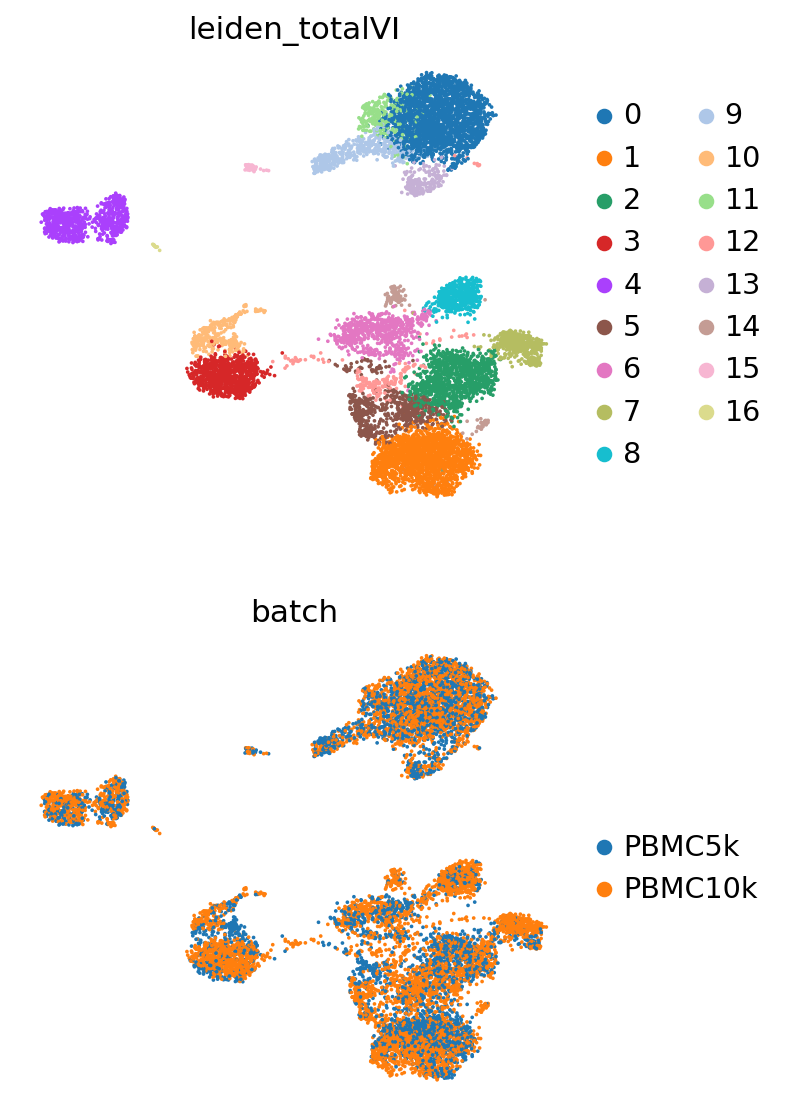

In [15]:
perm_inds = np.random.permutation(len(adata))
sc.pl.umap(
    adata[perm_inds],
    color=["leiden_totalVI", "batch"],
    ncols=1,
    frameon=False,
)

In [16]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate(
    [adata.obsm["protein_expression"].values[batch == "PBMC10k"], held_out_proteins],
    axis=0,
)

# cleaner protein names
parsed_protein_names = [
    p.split("_")[0] for p in adata.obsm["protein_expression"].columns
]
for i, p in enumerate(parsed_protein_names):
    adata.obs[f"{p} imputed"] = protein_means.iloc[:, i]
    adata.obs[f"{p} observed"] = combined_protein[:, i]

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:444: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


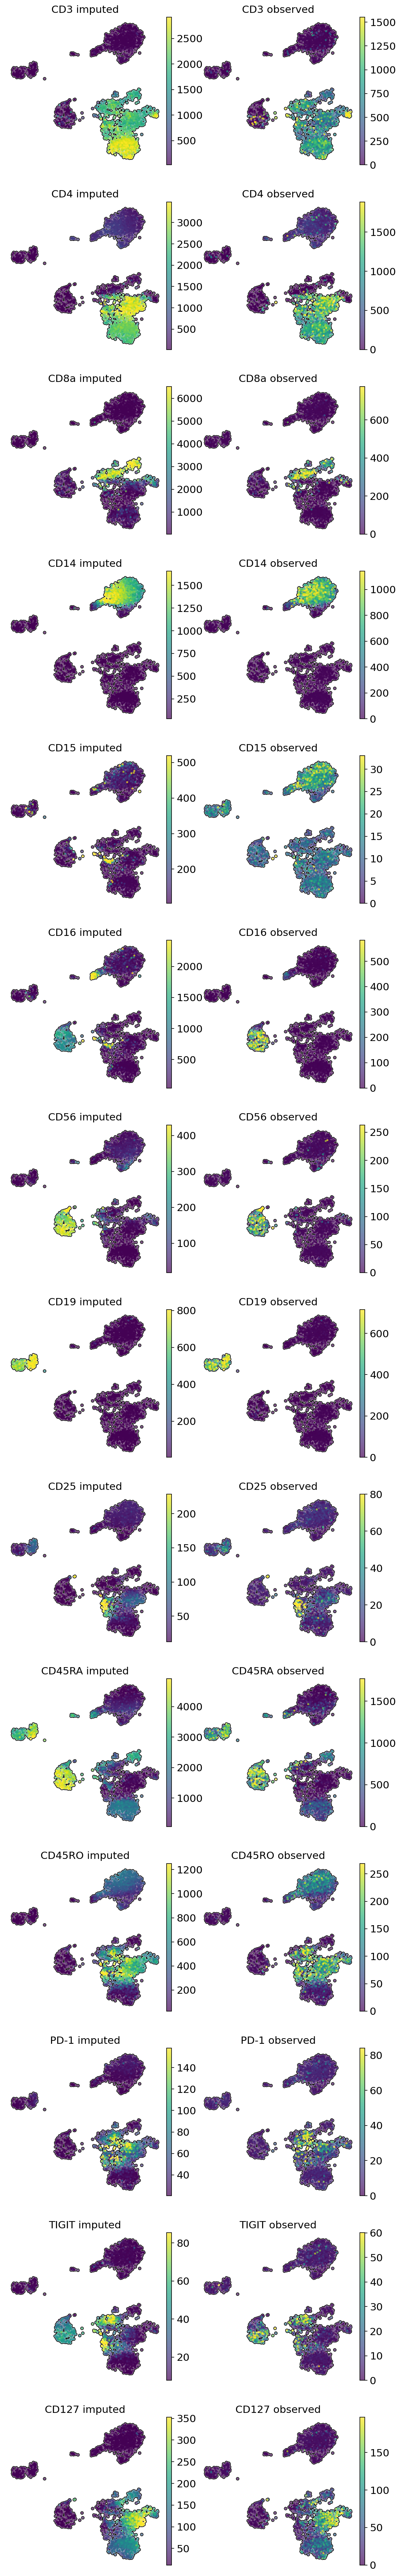

In [17]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.batch == "PBMC5k"],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1,
)

## Imputed vs denoised correlations

In [18]:
imputed_pros = protein_means[batch == "PBMC5k"]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(
        parsed_protein_names[i]
        + ": Corr="
        + str(
            np.round(
                pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3
            )
        )
    )
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)           Protein
0        3.258097       3.602617   CD3: Corr=0.788
1        5.105945       6.071169   CD4: Corr=0.869
2        2.833213       3.470926  CD8a: Corr=0.835
3        6.546785       7.191322  CD14: Corr=0.912
4        2.995732       4.782370  CD15: Corr=0.056

We notice that CD15 has a really low correlation (imputation accuracy). Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


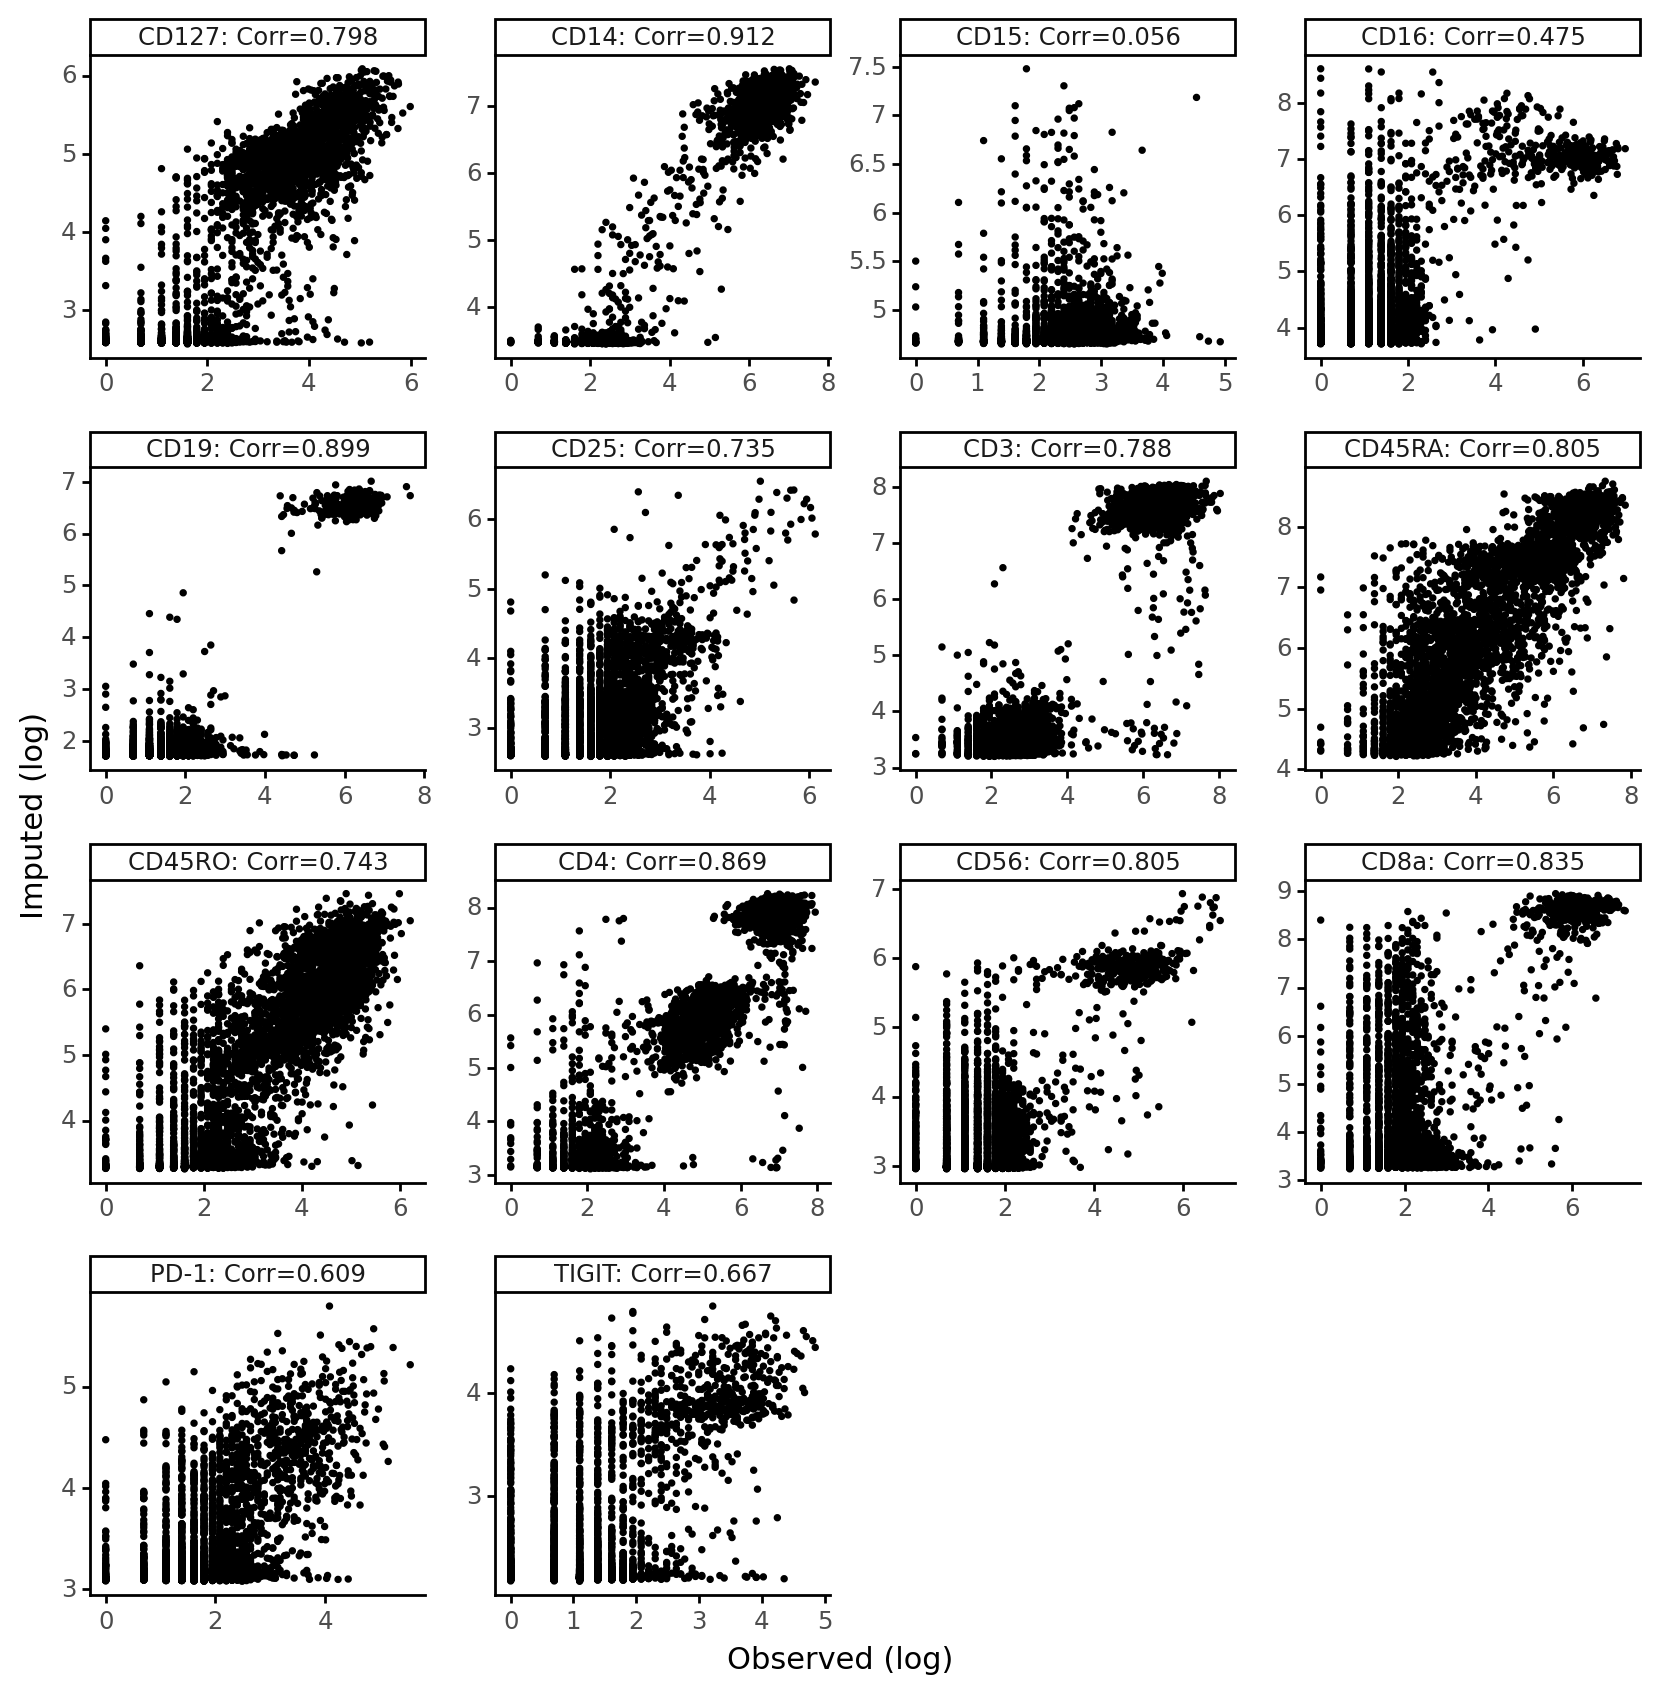

<ggplot: (8786190404458)>

In [19]:
p9.theme_set(p9.theme_classic)
(
    p9.ggplot(held_vs_denoised, p9.aes("Observed (log)", "Imputed (log)"))
    + p9.geom_point(size=0.5)
    + p9.facet_wrap("~Protein", scales="free")
    + p9.theme(
        figure_size=(10, 10),
        panel_spacing=0.35,
    )
)